In [1]:
import sys; sys.path.insert(1, '../')
from utils import *
from pytorch_stats_loss import torch_wasserstein_loss, torch_energy_loss
from geomloss import SamplesLoss

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.datasets import make_circles
from scipy.stats import *

# for ploting only
%matplotlib inline
import matplotlib.pyplot as plt
# import cufflinks as cf
# import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.graph_objects as go
init_notebook_mode(connected=True)
# cf.go_offline()

# tracking
from tqdm import trange

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


In [2]:
def get_label(Xs): return multivariate_normal.pdf(Xs, mean=np.array([1.0, 0]), cov=np.eye(X.shape[1]))

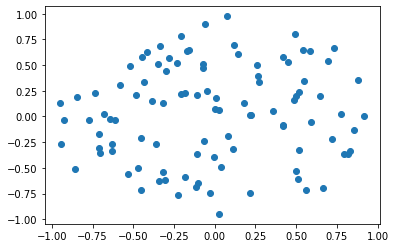

In [3]:
N = 2000
X = sampling_unit_circle(100)
y = get_label(X)
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [4]:
# fig = go.Figure(data=go.Contour(z=y, x=X[:, 0], y=X[:, 1]))
# fig.show()

In [5]:
# converting data to torch.tensor 
X = to_tensor(X, False)
y = to_tensor(y, False).reshape(-1, 1)

# setting the networks
solver = TorchMLP([2, 32, 32, 1])
generator = TorchMLP([2, 32, 32, 2])
solver_optimizer = torch.optim.Adam(solver.parameters(), lr=5e-3)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

# training configs
epochs = 10000
lb, ub = -2, 2
adv_f = 100

Using old implementation of TorchMLP. See models.py for more new model-related source code.
Using old implementation of TorchMLP. See models.py for more new model-related source code.


In [6]:
gen_loss = torch_wasserstein_loss

In [7]:
for i in trange(0, epochs):
    if i%adv_f==0:
        # train generator
        print("Training the generator")
        for _ in range(2000):
            solver.eval()
            generator.train()
            solver_optimizer.zero_grad()
            generator_optimizer.zero_grad()
            X_gen = generator(X)
            X_gen = scale_to_range(X_gen, lb, ub)
            y_gen = to_tensor(get_label(to_numpy(X_gen)), False).reshape(-1, 1)
            distance_loss = gen_loss(X_gen[:, 0:1], X[:, 0:1])+gen_loss(X_gen[:, 1:2], X[:, 1:2])
#             distance_loss = gen_loss(X_gen, X)
            pred = solver(X_gen)
            adv_loss = -F.mse_loss(pred, y_gen)
            generator_loss = distance_loss+adv_loss
            generator_loss.backward(retain_graph=True)
            generator_optimizer.step()

    # train solver
    solver.train()
    generator.eval()
    solver_optimizer.zero_grad()
    generator_optimizer.zero_grad()
    X_train = torch.cat([X, X_gen], dim=0).detach()
    y_train = torch.cat([y, y_gen], dim=0).detach()
    pred = solver(X_train)
    solver_loss = F.mse_loss(pred, y_train)
    solver_loss.backward(retain_graph=True)
    solver_optimizer.step()
    
    if i%1000==0:
        print("Epoch:", str(i), solver_loss.item())
        print("Epoch:", str(i), generator_loss.item())

  0%|          | 0/10000 [00:00<?, ?it/s]

Training the generator


  0%|          | 1/10000 [00:03<8:43:31,  3.14s/it]

Epoch: 0 0.0360715314745903
Epoch: 0 -0.06026080995798111
Training the generator


  1%|          | 101/10000 [00:06<6:04:23,  2.21s/it]

Training the generator


  2%|▏         | 201/10000 [00:09<4:14:04,  1.56s/it]

Training the generator


  3%|▎         | 301/10000 [00:12<2:57:32,  1.10s/it]

Training the generator


  4%|▍         | 401/10000 [00:15<2:04:32,  1.28it/s]

Training the generator


  5%|▌         | 501/10000 [00:18<1:27:34,  1.81it/s]

Training the generator


  6%|▌         | 601/10000 [00:21<1:01:55,  2.53it/s]

Training the generator


  7%|▋         | 701/10000 [00:24<44:08,  3.51it/s]  

Training the generator


  8%|▊         | 801/10000 [00:26<31:46,  4.83it/s]

Training the generator


  9%|▉         | 901/10000 [00:29<23:15,  6.52it/s]

Training the generator


 10%|█         | 1001/10000 [00:32<17:19,  8.66it/s]

Epoch: 1000 4.531971171672922e-06
Epoch: 1000 -7.125810498109786e-06
Training the generator


 11%|█         | 1101/10000 [00:34<13:11, 11.24it/s]

Training the generator


 12%|█▏        | 1201/10000 [00:37<10:22, 14.14it/s]

Training the generator


 13%|█▎        | 1301/10000 [00:40<08:19, 17.40it/s]

Training the generator


 14%|█▍        | 1400/10000 [00:42<04:21, 32.89it/s]


KeyboardInterrupt: 

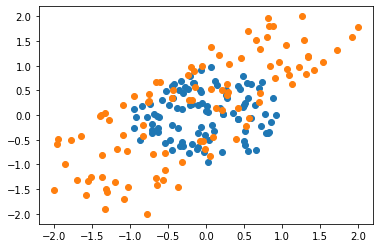

In [8]:
plt.scatter(to_numpy(X)[:, 0], to_numpy(X)[:, 1])
plt.scatter(to_numpy(X_gen)[:, 0], to_numpy(X_gen)[:, 1])
plt.show()